# Decitabine treatment Differential stability 
> #### REMoving Bias from Rna-seq ANalysis of Differential Transcript Stability
[REMBRANDTS](https://github.com/csglab/REMBRANDTS) is a package for analysis of RNA-seq data across multiple samples in order to obtain unbiased estimates of differential mRNA stability. It uses DESeq to obtain estimates of differential pre-mRNA and mature mRNA abundance across samples, and then estimates a gene-specific bias function that is then subtracted from Δexon–Δintron to provide unbiased differential mRNA stability measures.

## Load packages and functions

In [1]:
# %reload_ext rpy2.ipython

In [2]:
# %%R
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(Biobase)))
suppressMessages(suppressWarnings(library(rtracklayer)))
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(ggrepel)))
suppressMessages(suppressWarnings(library(patchwork)))
suppressMessages(suppressWarnings(library(gridExtra)))
library(grid)
library(ggthemes)


In [4]:
# %%R 
run_norm <- function(eset){
    eset_norm <- eset
    # Log tranform
    exprs(eset_norm) <- log1p(exprs(eset_norm))
    # Quantile normalize
    exprs(eset_norm) <- normalizeBetweenArrays(exprs(eset_norm))
    
    return(eset_norm)
}
    
run_limma <- function(eset,design, cm){
    # Fit coefficients 
    fit <- lmFit(eset, design)
    # Fit contrasts 
    fit2 <- contrasts.fit(fit, contrasts = cm)
    # Calculate t-statistics 
    fit2 <- eBayes(fit2)
    return (fit2)
}

get_res<- function(fit,coef){
    res <- cbind(
        fit[,coef]$coef [,coef] %>% data.frame %>% rename(log2FoldChange='.'),
        fit[,coef]$p.value [,coef] %>% data.frame %>% rename(pvalue='.'),
        fit$genes %>% data.frame %>% select(name)
    )
    return(res)
}

boxplot_top_hit <- function (eset,gene_name){
    gene = (fData(eset) %>% rownames_to_column('row'))$row[fData(eset)$name == gene_name]
    # Create a boxplot of a given gene
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "cond"],main = fData(eset)[gene, "name"])
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "time"],main = fData(eset)[gene, "name"])
}


In [5]:
# %%R 
plot_volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title=''){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    ## Volcano plot
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
    #         xlim(c(-20,20)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none",plot.title = element_text(hjust = 0.5,face = "bold")) +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:5,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            ) 
    
     return (vol)
}

## Load annotations

In [6]:
# %%R
# GTF = '/rumi/shams/genomes/hg38/hg38_ensemble_genes.gtf'
GTF = '~/genomes/hg38/hg38_ensemble_genes.gtf'

gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

## Load estimated RNA stability data 

In [7]:
# Read `REMBRANDTS` results
stbl = read.csv('stbl/REMBRANDTS.txt', sep='\t') %>% column_to_rownames('GeneID')

Make meta table:

In [9]:
# meta 
lines   <- c(rep('hl60',12),lapply(
    c('kg1', 'molm13', 'molm14', 'ociaml3', 'skm1'), rep, 6) %>% unlist)

# 'ociaml2', 'thp1'

# meta 
conds  <- factor(c(
    # hl60
    rep(c(rep('Decitabine',2),rep('DMSO',2)),3),
    # other cell lines
    rep(c(rep('Decitabine',3), rep('DMSO',3)),5)
), levels = c('DMSO','Decitabine'))

reps <- factor(c(
    # hl60
    rep(c('rep1','rep2'),6),
    # other cell lines
    rep(c('rep1','rep2','rep3'),10)
),c('rep1','rep2','rep3'))

hours <- factor(c(
    # hl60
    c(rep('120h',4),rep('6h',4),rep('72h',4)), 
    # other cell lines
    rep('72h',30)
),c('6h','72h','120h') )

colData <- data.frame(
    line=lines, 
    cond=conds,
    time=hours,
    group = paste(conds,hours, sep='.'),
    reps=reps,
    row.names=stbl %>% colnames,
    stringsAsFactors=FALSE
)

colData

,line,cond,time,group,reps
,<chr>,<fct>,<fct>,<chr>,<fct>
hl60_120h_t_1,hl60,Decitabine,120h,Decitabine.120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,Decitabine.120h,rep2
hl60_120h_u_1,hl60,DMSO,120h,DMSO.120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,DMSO.120h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,Decitabine.6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,Decitabine.6h,rep2
hl60_6h_u_1,hl60,DMSO,6h,DMSO.6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,DMSO.6h,rep2
hl60_72h_t_1,hl60,Decitabine,72h,Decitabine.72h,rep1


## Differential stability analysis with `limma`
`limma` is originally design for micro-array experiments which is mainly doing same task as `DESeq2`.  Comparing to RNA expression analysis, RNA stability may have negetive values; `DESeq2` does not support negetive values but `Limma` does. Therefore, we decided to use `Limma` package instead of `DESeq2` for differential analysis. 


<!--   - #### [Decitabine treatment time-series RNA-Seq experiments in HL60 cell line](#Decitabine-treatment-time-series-RNA-Seq-experiments-in-HL60-cell-line)
  - #### [Decitabine treatment RNA-Seq experiments in 5 other AML cell lines](#Decitabine-treatment-RNA-Seq-experiments-in-5-other-AML-cell-lines)
 -->
<!-- I've learned how to use limma from this [DataCamp course | differential-expression-analysis-with-limma-in-r](https://campus.datacamp.com/courses/differential-expression-analysis-with-limma-in-r/). 
However, I found these links useful while browsing. 
- http://genomicsclass.github.io/book/pages/using_limma.html
- https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html
 -->
<!--     1) time-series RNA-Seq experiments in HL60 cell line -->

In [10]:
# Make annotation dataframe 
ann = data.frame(
    name=gene2name[rownames(stbl),],
    row.names=rownames(stbl)
)

eset <- ExpressionSet(
    assayData = as.matrix(stbl),
    phenoData = AnnotatedDataFrame(colData),
    featureData = AnnotatedDataFrame(ann)
)

# normalize across all experiments
exprs(eset) <- exprs(eset %>% run_norm)

Warning message in log1p(exprs(eset_norm)):
“NaNs produced”


In [11]:
# write all normalized counts into a file
cbind(fData(eset),exprs(eset)) %>% 
    write.table(
        'stbl/normalized_stbl_count_table.txt', quote = F, 
        col.names=TRUE, row.names=TRUE,sep ='\t'
    )

In [12]:
make_comp_res <- function(e,m=~0+cond){
    d <- model.matrix(m, pData(e))
    # contrast design
    cm <- makeContrasts(comp= condDecitabine - condDMSO,levels = d)
    f <- e %>% run_limma (d, cm)
    res <- get_res(f,'comp') 
    return(res)
}

In [14]:
results = list()

## hl60 cell line
results$hl60_120h <- make_comp_res(
    eset[,eset@phenoData@data$line == 'hl60' & eset@phenoData@data$time == '120h']
)
results$hl60_72h <- make_comp_res(
    eset[,eset@phenoData@data$line == 'hl60' & eset@phenoData@data$time == '72h']
)
results$hl60_6h <- make_comp_res(
    eset[,eset@phenoData@data$line == 'hl60' & eset@phenoData@data$time == '6h']
)
## other cell line
for (line in c('kg1','molm13','molm14','ociaml3','skm1')){
    results[[line]]<- make_comp_res(
        eset[,eset@phenoData@data$line == line]
    )
}

Warning message:
“Partial NA coefficients for 226 probe(s)”
Warning message:
“Partial NA coefficients for 217 probe(s)”
Warning message:
“Partial NA coefficients for 202 probe(s)”
Warning message:
“Partial NA coefficients for 54 probe(s)”
Warning message:
“Partial NA coefficients for 67 probe(s)”
Warning message:
“Partial NA coefficients for 46 probe(s)”
Warning message:
“Partial NA coefficients for 71 probe(s)”
Warning message:
“Partial NA coefficients for 99 probe(s)”


In [15]:
result_table = data.frame(
    gene_name=fData(eset)$name,
    gene_id=fData(eset) %>% rownames
)

for (name in names(results)){
    result_table[paste0(name,'_log2FC')] = results[[name]]$log2FoldChange
    result_table[paste0(name,'_pvalue')] = results[[name]]$pvalue
}

result_table <- result_table %>% column_to_rownames('gene_id')

In [16]:
# write all results into one file 
write.table(result_table, 'stbl/delta_stbl_table.txt', quote = F, col.names=TRUE, row.names=TRUE,sep ='\t')

## Plots

### Correlation matrix

In [18]:
library(Hmisc)
library(corrplot)
library(pheatmap)
library(ggcorrplot)

In [19]:
all_fc <- result_table %>% select(ends_with("log2FC")) 
colnames(all_fc) <- colnames(all_fc) %>% stringr::str_remove(pattern = "_log2FC") %>% unlist


In [24]:
corr <- rcorr(
    as.matrix(
        all_fc %>% select('hl60_6h','hl60_72h','hl60_120h','molm13','skm1','kg1','molm14','ociaml3')
    )
)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



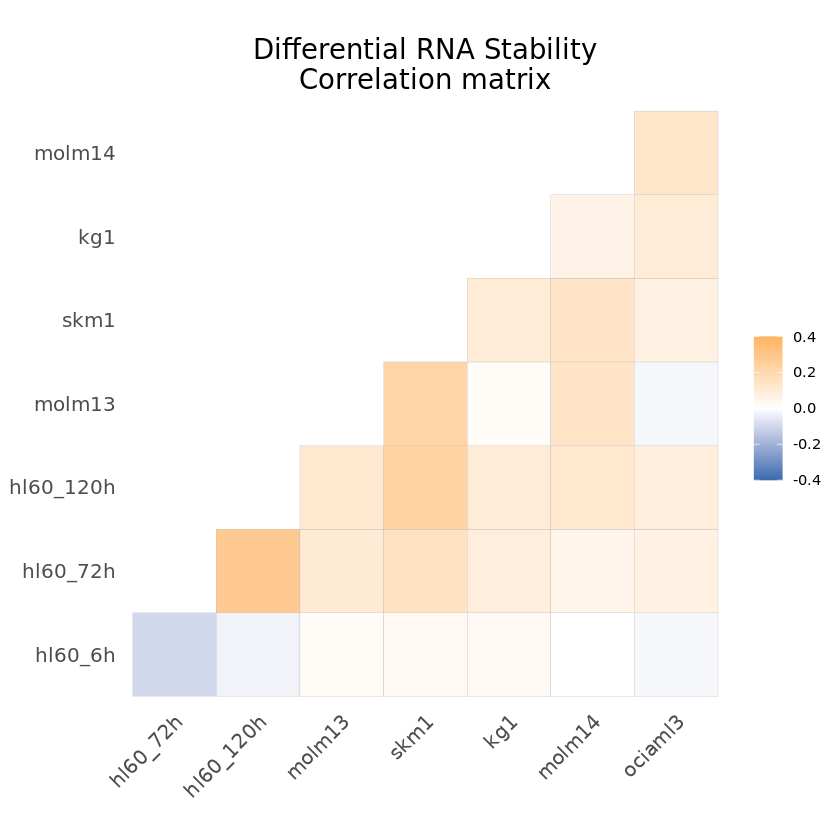

In [25]:
colors=c("#386cb0","white","#fdb462")
ggcorrplot(
    corr$r, 
    method = c("square", "circle"),
    # hc.order = TRUE,
    type = "lower", p.mat = corr$p,
    
) + ggtitle(
    "Differential RNA Stability\nCorrelation matrix"
) + ggplot2::scale_fill_gradient2(
    low = colors[1], high = colors[3], mid = colors[2], 
    midpoint = 0, limit = c(-0.4, 0.4), space = "Lab"
) + theme(
    plot.title = element_text(
        # face = "bold",
        size = rel(1.5), hjust = 0.5),
    panel.background = element_blank(), 
    panel.border = element_blank(), 
    panel.grid.major = element_line(colour = "white"), 
    legend.title = element_blank(),
    # legend.position="bottom"
)

ggsave('stbl/plots/logFC_corr.pdf',width = 4, height = 4)

### Volcano Plots

In [26]:
# %%R 
# p1 = res_kg1 %>% 
# plot_volcano (title='RNA Stability\nkg1 cell line')

# p2 = res_molm14 %>% 
# plot_volcano (title='molm14 cell line')

# p3 = res_ociaml2 %>% 
# plot_volcano (title='ociaml2 cell line')

# p4 = res_ociaml3 %>% 
# plot_volcano (title='ociaml3 cell line')

# p5 = res_thp1 %>% 
# plot_volcano (title='thp1 cell line')

# p1$labels$x <- p2$labels$x <- p3$labels$x <- p4$labels$x <- " "


In [27]:
# %%R 
# (p1 / p2 / p3 / p4 / p5) + plot_layout(widths = c(1, 25))

In [28]:
# # Plot principal components labeled by treatment
# col_by_cond=rep(c(rep("black",2), rep("red",2)),3)
# plotMDS(ESETs$hl60, labels = pData(ESETs$hl60)[, "time"], col=col_by_cond, gene.selection = "common")

In [29]:
# df_sig = results %>% rownames_to_column %>% 
#     filter (
#         hl60.72h.stbl.log2FoldChange > 1 & hl60.72h.stbl.pvalue < 0.05 
# #         P.Value_120h   < 0.001 |
# #         adj.P.Val_6h   < 0.05 
# #         adj.P.Val_120h < 0.05)
#            ) %>% 
#     remove_rownames %>% column_to_rownames('rowname') 

# df_sig %>% head

### Clustering 

In [30]:
library(RColorBrewer)

heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
greens <- brewer.pal(n = 9, name = "Greens")

### Heatmap to show HL-60 time series clusters

png 
  2

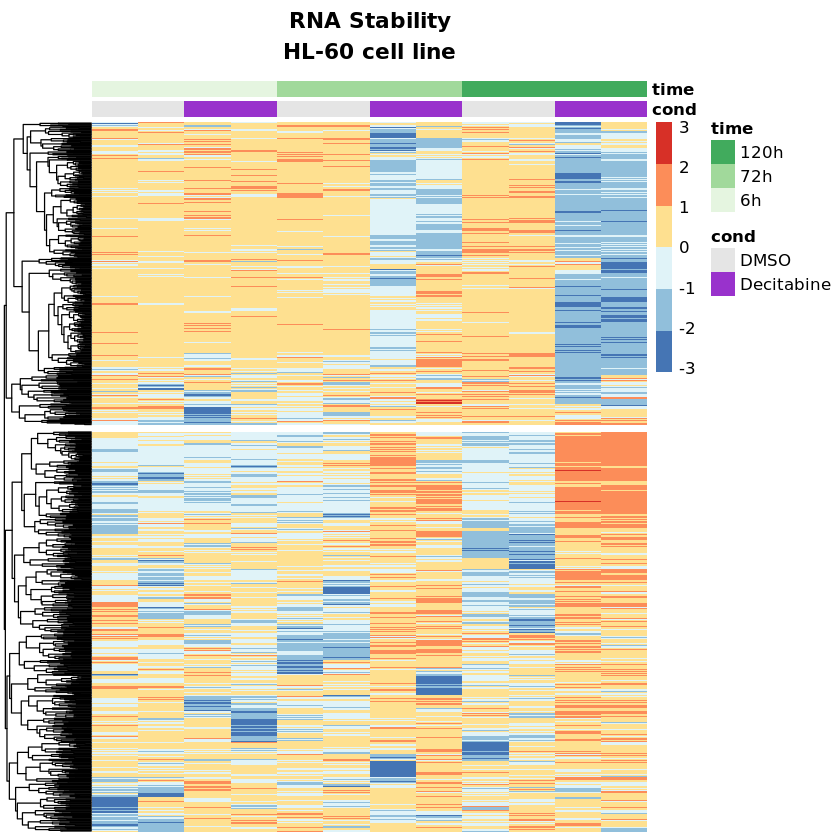

In [31]:
ann_colors = list(
    cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
    time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
)


exprs(eset)[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        filter(
            (abs(hl60_6h_log2FC)  > 0.5 & hl60_6h_pvalue   < 0.01) |
            (abs(hl60_72h_log2FC) > 0.5 & hl60_72h_pvalue  < 0.01)|
            (abs(hl60_120h_log2FC)> 0.5 & hl60_120h_pvalue < 0.01) 
        ) %>% 
        rownames
    , 
    # subset normalized counts
    colData[colData$line=='hl60',c('cond','time')] %>% arrange(time,cond) %>% rownames
] %>% data.frame %>% replace(is.na(.), 0) %>% 
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = F,
        cutree_rows = 2,
        main = 'RNA Stability\nHL-60 cell line',
        annotation = colData[colData$line=='hl60',c('cond','time')],
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_hl60

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('stbl/plots/heatmap_clustering_hl60.pdf', width=4, height=7)
grid::grid.newpage()
grid::grid.draw(hm_hl60$gtable)
dev.off()

### Heatmap to show cell line consistency 

### volcano plots

In [32]:
# p1 = res_6h %>% 
# plot_volcano (title='RNA Stability\nhl60 cell line treated for 6h\nnot normalized')

# p2 = res_norm_6h %>% 
# plot_volcano (title='normalized')

# p3 = res_120h %>% 
# plot_volcano (title='RNA Stability\nhl60 cell line treated for 120h\nnot normalized')

# p4 = res_norm_120h %>% 
# plot_volcano (title='normalized')

# (p1 / p2)

In [33]:
# %%R 
# (p3 / p4)

In [34]:
# p1 = res_72h %>% 
# plot_volcano (title='RNA Stability\nhl60 cell line treated for 72h\nnot normalized')

# p2 = res_norm_72h %>% 
# plot_volcano (title='')

# # p1 / 
# p2

In [35]:
# %%R 
# boxplot_top_hit(eset, 'USP3')

In [36]:
# boxplot_top_hit(ESETs$hl60 %>% run_norm, 'USP3')

___

## Enrichment analysis

Write iGET friendly tables:

In [37]:
for (name in names(results)){
    write.table(
        results[[name]][,c('name','log2FoldChange')],
        paste0('stbl/',name,'_delta_stbl.txt'), 
        quote = F, col.names=FALSE, row.names=FALSE,sep ='\t'
    )
}

#
___

In [38]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2   ggcorrplot_0.1.3     pheatmap_1.0.12     
 [4] corrplot_0.92        Hmisc_4.6-0          Formula_1.2-4       
 [7] survival_3.2-13      lattice_0.20-45      ggthemes_4.2.4      
[10] gridExtra_2.3        patchwork_1.1.1      ggrepel_0.9.1  

In [39]:
date()

[1] "Wed Aug 30 16:02:29 2023"